In [10]:
from __future__ import print_function, division
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Datasets')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 chest_30x30.pth     dict_45x45_100epoch.pth  'Lungnet DOCS.gdoc'
 chest_xray	     dict_save_64x64.pth       runs
 ChestXRay2017.zip   logs		       weights


In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.RandomResizedCrop(45),      
        transforms.RandomVerticalFlip(p=0.6),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]) 
    ]),
    'val': transforms.Compose([      
        transforms.Resize((512,512)),   
        transforms.RandomResizedCrop(45),        
        transforms.RandomVerticalFlip(p=0.6),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),
}
data_dir = 'chest_xray'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=2,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

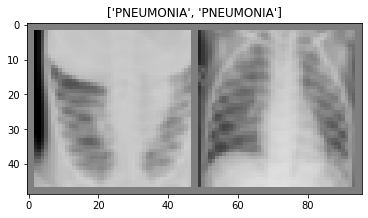

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([.5])
    std = np.array([.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:

#writer = SummaryWriter()

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
              
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            ##for tensorboard
            #writer.add_scalar('loss1' , loss.item() , globaliter)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    #writer.close()
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
class Lungnet(nn.Module): 
      #input of 45x45x3
    def __init__(self):
        super(Lungnet, self).__init__()
        

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size= 7,padding=0,stride=1)# output 39x39x32
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size= 6,padding=0,stride=1)# output 34x34x64
        self.pool1 = nn.MaxPool2d(kernel_size=20,stride=1)## output 15x15x64

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size= 5,padding=0,stride=1)# output 11x11x128
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size= 4,padding=0,stride=1)# output 8x8x256

        self.conv5 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size= 3,padding=0,stride=1)# output 6x6x512
        self.conv6 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size= 3,padding=0,stride=1)# output 4x4x512
        
        self.fc1 = nn.Linear(8192, 2048)
        self.drop1=nn.Dropout2d(p=.6)
        self.fc2 = nn.Linear(2048, 2048)
        self.drop2=nn.Dropout2d(p=.6)
        self.fc3 = nn.Linear(2048, 2)   
        
    def forward(self, x):
     
        x=F.leaky_relu(self.conv1(x))
        x=F.leaky_relu((self.conv2(x)))        
        x=self.pool1(x)
        x=F.relu(self.conv3(x))     
        x=F.relu(((self.conv4(x))))
        x=F.relu(((self.conv5(x))))
        x=F.relu(((self.conv6(x)))) 

        #print(x.shape)

        x=x.view(-1, 512*4*4)      
      
        x = F.leaky_relu(self.fc1(x))
        x=self.drop1(x)
        x = F.leaky_relu(self.fc2(x))
        x=self.drop2(x)
        x = F.relu(self.fc3(x))     
        return x

lungnet = Lungnet()
lungnet.to(device)      



Lungnet(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=20, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=8192, out_features=2048, bias=True)
  (drop1): Dropout2d(p=0.6, inplace=False)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (drop2): Dropout2d(p=0.6, inplace=False)
  (fc3): Linear(in_features=2048, out_features=2, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(lungnet.parameters(), lr=.001, momentum=0.9)
#optimizer_ft = optim.Adam(lungnet.parameters(), lr=1.0, weight_decay=1.0)
# Decay LR by a factor of 0.1 every 10 epochs
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

In [8]:
model_ft = train_model(lungnet, criterion, optimizer_ft, scheduler,num_epochs=100)

Epoch 0/99
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5724 Acc: 0.7425
val Loss: 0.6554 Acc: 0.6250

Epoch 1/99
----------
train Loss: 0.5046 Acc: 0.7415
val Loss: 0.5543 Acc: 0.6971

Epoch 2/99
----------
train Loss: 0.4437 Acc: 0.7900
val Loss: 0.6526 Acc: 0.6827

Epoch 3/99
----------
train Loss: 0.4144 Acc: 0.8079
val Loss: 0.5415 Acc: 0.7212

Epoch 4/99
----------
train Loss: 0.3802 Acc: 0.8291
val Loss: 0.4633 Acc: 0.8093

Epoch 5/99
----------
train Loss: 0.3559 Acc: 0.8459
val Loss: 0.4298 Acc: 0.7997

Epoch 6/99
----------
train Loss: 0.3669 Acc: 0.8373
val Loss: 0.5068 Acc: 0.8061

Epoch 7/99
----------
train Loss: 0.3474 Acc: 0.8506
val Loss: 0.4622 Acc: 0.8141

Epoch 8/99
----------
train Loss: 0.3324 Acc: 0.8577
val Loss: 0.5110 Acc: 0.7869

Epoch 9/99
----------
train Loss: 0.2948 Acc: 0.8733
val Loss: 0.3897 Acc: 0.8429

Epoch 10/99
----------
train Loss: 0.2848 Acc: 0.8785
val Loss: 0.4800 Acc: 0.8077

Epoch 11/99
----------
train Loss: 0.2768 Acc: 0.8827
val Loss: 0.4947 Acc: 0.8061

Epoch 12/99
----------
t

In [0]:
torch.save(model_ft.state_dict(), 'dict_45x45_100epoch.pth')

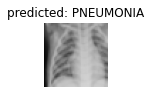

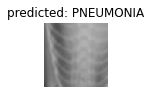

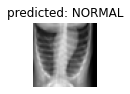

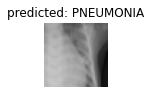

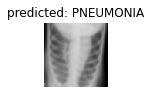

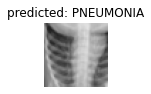

In [13]:
visualize_model(model_ft)